In [1]:
%cd /home/ubuntu/eda/flood-risk/modeling/data
from osgeo import gdal, gdal_array, osr, ogr
import numpy as np
import rasterio
from rasterio import mask
import pyproj
from affine import Affine
import pandas as pd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import geopandas as gpd
from rasterio.features import shapes
import xarray
import matplotlib.pyplot as plt
import rtree
import shapely
import warnings
import time
from scipy.cluster.hierarchy import dendrogram


from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, AffinityPropagation
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import *
from sklearn.decomposition import PCA
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler
from itertools import combinations
# import hdbscan

warnings.filterwarnings('ignore')

[Errno 2] No such file or directory: '/home/ubuntu/eda/flood-risk/modeling/data'
/Users/grantwilson/mids/flood-risk/modeling


ModuleNotFoundError: No module named 'osgeo'

#### High Water Mark

In [2]:
hw = pd.read_csv('./FilteredHWMs_Ida.csv')
hw.columns = hw.columns.str.lower()
hw = hw[hw.eventname == '2021 Ida']
hw = gpd.GeoDataFrame(hw[['eventname','hwmtypename', 'site_no', 'sitedescription','site_latitude', 'site_longitude', 'hwm_id','waterbody', 'site_id', 'hwm_type_id', 'hwm_quality_id','hwm_locationdescription', 'survey_date', 'elev_ft','height_above_gnd','hwm_notes', 'flag_date', 'stillwater','uncertainty','hwm_label']], 
                      geometry = gpd.points_from_xy(hw['longitude_dd'],hw['latitude_dd'])).set_crs(4326).to_crs(2263)
hw = hw[['eventname','hwm_id','site_no','site_latitude','site_longitude','waterbody','survey_date','elev_ft','height_above_gnd','stillwater','geometry']].sort_values(by = ['site_no','height_above_gnd'], ascending = False).groupby('site_no').head(1)

In [3]:
hw.describe()

,hwm_id,site_latitude,site_longitude,elev_ft,height_above_gnd,stillwater
count,83.000000,83.000000,83.000000,83.000000,79.000000,83.000000
mean,41233.590361,40.724783,-73.929262,40.631325,1.999620,0.132530
std,244.782484,0.078262,0.103482,38.800185,1.525491,0.341127
min,40946.000000,40.589173,-74.156753,3.700000,0.000000,0.000000
25%,40993.000000,40.672010,-73.985231,15.600000,0.925000,0.000000
50%,41183.000000,40.718217,-73.900633,29.800000,1.630000,0.000000
75%,41444.500000,40.761889,-73.847039,58.100000,2.435000,0.000000
max,41679.000000,40.894233,-73.765239,240.700000,6.510000,1.000000


#### Sandy Inundation

In [4]:
sd = gpd.read_file('./sandy_inundation.shp').set_crs(4326).to_crs(2263)

In [5]:
sd.head()

,geometry
0,"POLYGON ((918494.320 128523.034, 918492.192 12..."
1,"POLYGON ((948808.195 138356.716, 948810.318 13..."
2,"POLYGON ((1009053.467 160146.572, 1009051.883 ..."
3,"POLYGON ((975521.372 160027.088, 975517.667 16..."
4,"POLYGON ((989512.654 160750.173, 989515.302 16..."


#### NYC Features

In [2]:
%cd /home/ubuntu/eda/data

/home/ubuntu/eda/data


"land_cvr_1":"tree_canopy_proportion"  
"land_cvr_2":"grass_proportion"  
"land_cvr_3":"soil_proportion"  
"land_cvr_4":"water_proportion"  
"land_cvr_5":"building_proportion"   
"land_cvr_6":"road_proportion"   
"land_cvr_7":"impervious_proportion"   
"land_cvr_8":"railroad_proportion"

In [3]:
ny = pd.read_csv('./ny_full_scaled.csv')
ny = gpd.GeoDataFrame(ny, geometry = ny['geometry'].apply(shapely.wkt.loads)).drop(columns = ['Unnamed: 0'])
ny = ny[ny['boroname'] != 'Staten Island']

In [4]:
ny['imperv_cvr'] = ny['land_cvr_5'] + ny['land_cvr_6'] + ny['land_cvr_7']
ny['perm_cvr'] = ny['land_cvr_1'] + ny['land_cvr_2'] + ny['land_cvr_3']

In [9]:
#geo feats and Ida high water marks
ny_hw = ny.sjoin(hw[['elev_ft','height_above_gnd','geometry']], how = 'inner', predicate = 'contains').sort_values(by = ['bctcb2020','height_above_gnd']).groupby('bctcb2020').head(1).drop(columns = ['index_right','cb2020','borocode','boroname','ct2020','geoid','geometry','ntaname']).set_index('bctcb2020')
ny_hw.head()

,shape_leng,shape_area,land_cvr_1,land_cvr_2,land_cvr_3,land_cvr_4,land_cvr_5,land_cvr_6,land_cvr_7,land_cvr_8,...,river_ind,stream_ind,wl_marsh_ind,beach_shore_ind,bay_ocean_ind,elev_mean_diff,imperv_cvr,perm_cvr,elev_ft,height_above_gnd
bctcb2020,,,,,,,,,,,,,,,,,,,,,
10143001001,5.026400,3.275649,1.694165,1.827652,0.972171,2.239673,-1.641641,-0.844516,-1.388076,-0.189784,...,0,0,0,0,0,-2.709566,-3.874232,4.493988,14.4,0.00
10287001006,-0.360039,-0.117529,-0.558164,-0.769017,-0.092682,-0.085076,0.860806,-0.001411,0.329599,-0.189784,...,0,0,0,0,0,-4.437698,1.188995,-1.419863,20.9,1.95
10297001003,6.432535,6.325506,4.778986,0.126734,0.313258,-0.058824,-1.666643,-1.048150,-1.986473,-0.189784,...,1,0,0,0,0,1.352224,-4.701266,5.218979,6.9,0.00
20046001008,-0.150070,-0.050504,2.859273,0.153450,-0.092682,-0.085076,-0.939228,-0.869277,-0.826934,-0.189784,...,0,0,0,0,0,-0.069743,-2.635439,2.920040,8.6,0.34
20132005003,0.065932,-0.010251,-0.997238,-0.096887,-0.092682,-0.085076,-0.024506,0.121026,1.244447,-0.189784,...,0,0,0,0,0,-0.233031,1.340967,-1.186807,10.0,1.70


#### RF Ida Watermarks

In [10]:
X_train, X_test, y_train, y_test = train_test_split(ny_hw.iloc[:,:-2], ny_hw.iloc[:,-2], test_size = 0.2, random_state = 25)

params = {
    'n_estimators':[150,200,250,300],
    'max_depth':[None, 6, 4, 3],
    'min_samples_split':[2,4],
    'min_samples_leaf':[1,2],
    'max_features':[None, 'sqrt', 'log2'],
    'max_leaf_nodes':[None],
    'random_state':[42],
    'warm_start':[False]
}

rf_cv = GridSearchCV(RandomForestRegressor(),
                        params,
                        scoring = 'r2',
                        cv = 5,
                        verbose = 1)
rf_cv.fit(X_train, y_train)
print(f'Best params:{rf_cv.best_estimator_}')
print(f'Train set R2: {rf_cv.best_score_}')

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Best params:RandomForestRegressor(max_depth=4, max_features='log2', min_samples_leaf=2,
                      n_estimators=200, random_state=42)
Train set R2: 0.39438255961966384


In [11]:
rf = RandomForestRegressor(n_estimators = 200, random_state = 42, max_features = 'log2', min_samples_leaf = 2, max_depth = 4)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f'Test set R2: {r2}')

Test set R2: 0.6665279001412396


In [12]:
pd.DataFrame(rf.feature_importances_, index = rf.feature_names_in_, columns = ['importance']).sort_values('importance', ascending = False)

,importance
elev_q1,0.094022
elev_min,0.093142
elev_min_ct,0.091985
elev_q1_ct,0.088798
elev_mean,0.072426
elev_mean_ct,0.068048
elev_q3,0.059150
elev_max,0.047295
elev_q3_ct,0.040162
land_cvr_2_ct,0.034224


### Binary Sandy Inundation

# Unsupervised

#### Determine # of Clusters

In [14]:
feat_cols = ['land_cvr_1', 'land_cvr_2',
        'land_cvr_5', 'land_cvr_6', 'land_cvr_7',
         'land_cvr_1_ct', 'land_cvr_2_ct',
        'land_cvr_5_ct', 'land_cvr_6_ct',
       'land_cvr_7_ct',  'elev_mean', 'elev_min', 'elev_max',
       'elev_q1', 'elev_q3', 'elev_var', 'elev_mean_ct', 'elev_min_ct',
       'elev_max_ct', 'elev_q1_ct', 'elev_q3_ct', 'elev_var_ct',
       'catch_basin_count', 'catch_basin_density', 
       'elev_mean_diff']

In [5]:
feat_subset = [
    # 'land_cvr_2',
        # 'land_cvr_5', 
               # 'land_cvr_6',
    'imperv_cvr'
    ,'perm_cvr'
          # 'land_cvr_2_ct',
        # 'land_cvr_5_ct', 
       # 'land_cvr_7_ct',  
               # 'elev_mean', 
               # 'elev_min', 
               # 'elev_max',
       ,'elev_q1' 
    # ,'elev_q3'
               # ,'elev_mean_ct'
               # 'elev_min_ct',
        ,'elev_q1_ct'
    ,'elev_mean'
    ,'elev_min'
               # ,'elev_q3_ct'
              ]

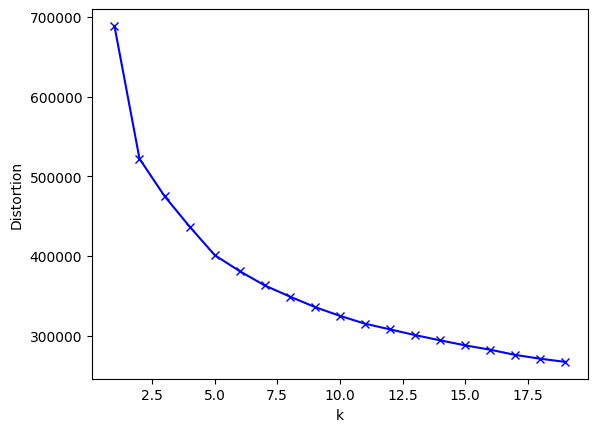

In [15]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_cols])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

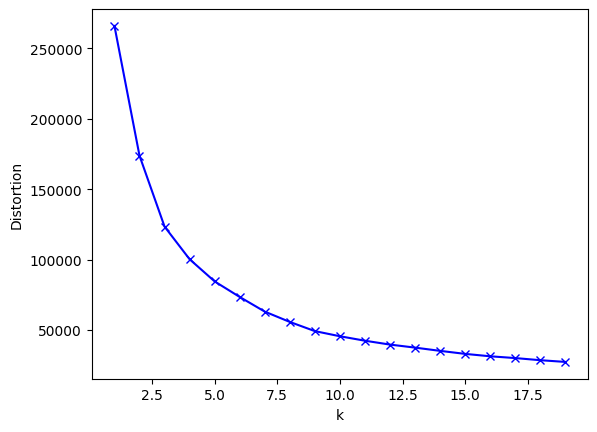

In [6]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(ny[feat_subset])
    distortions.append(kmeanModel.inertia_)
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

In [7]:
#range: [-1,1], 1 is best, close to 0 indicates overlapping clusters, negative indicates values assigned to wrong cluster
def cv_silhouette_score(estimator, X):
    estimator.fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    num_samples = len(X.index)
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return silhouette_score(X, cluster_labels)

In [8]:
# ny.columns

# Clustering Methods

In [9]:
feat_data = ny.set_index('bctcb2020').drop(columns = ['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname'])

In [10]:
def model_train_eval(model_obj, X, cv = False, params = None):

    model = model_obj.fit(X)
        # core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
        # core_samples_mask[model.core_sample_indices_] = True
    labels = model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))

### Agglomerative

In [11]:
#grouped LC vars, addtl elev vars
n_clusters = [5,6,7]
for n in n_clusters:
    ac = AgglomerativeClustering(n_clusters = n)
    model_train_eval(ac, feat_data[feat_subset])
    print('-'*15)

Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.256
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.272
---------------
Estimated number of clusters: 7
Estimated number of noise points: 0
Silhouette Coefficient: 0.277
---------------


### DBSCAN

In [ ]:
# eps =[0.5,0.75,1,1.25]
# min_samples = [5,8,10]
# for e in eps:
#     for m in min_samples:
#         print(f'Max dist:{e}, min samples:{m}')
#         model_train_eval(DBSCAN(eps = e, min_samples = m), feat_data[feat_subset])
#         print('-'*15)

In [12]:
#grouped LC vars, addtl elev vars
eps =[0.875,1,1.125,1.25]
min_samples = [5,7,9,11]
for e in eps:
    for m in min_samples:
        print(f'Max dist:{e}, min samples:{m}')
        model_train_eval(DBSCAN(eps = e, min_samples = m), feat_data[feat_subset])
        print('-'*15)

Max dist:0.875, min samples:5
Estimated number of clusters: 9
Estimated number of noise points: 200
Silhouette Coefficient: 0.383
---------------
Max dist:0.875, min samples:7
Estimated number of clusters: 6
Estimated number of noise points: 269
Silhouette Coefficient: 0.455
---------------
Max dist:0.875, min samples:9
Estimated number of clusters: 1
Estimated number of noise points: 357
Silhouette Coefficient: 0.622
---------------
Max dist:0.875, min samples:11
Estimated number of clusters: 1
Estimated number of noise points: 387
Silhouette Coefficient: 0.615
---------------
Max dist:1, min samples:5
Estimated number of clusters: 4
Estimated number of noise points: 117
Silhouette Coefficient: 0.484
---------------
Max dist:1, min samples:7
Estimated number of clusters: 4
Estimated number of noise points: 168
Silhouette Coefficient: 0.469
---------------
Max dist:1, min samples:9
Estimated number of clusters: 4
Estimated number of noise points: 221
Silhouette Coefficient: 0.459
-----

#### KMeans

In [13]:
# n_clusters = [5,6,7]
# for n in n_clusters:
#     km = KMeans(n_clusters = n)
#     model_train_eval(km, feat_data[feat_subset])
#     print('-'*15)

In [14]:
#grouped LC vars, addtl elev vars
n_clusters = [5,6,7]
for n in n_clusters:
    km = KMeans(n_clusters = n)
    model_train_eval(km, feat_data[feat_subset])
    print('-'*15)

Estimated number of clusters: 5
Estimated number of noise points: 0
Silhouette Coefficient: 0.356
---------------
Estimated number of clusters: 6
Estimated number of noise points: 0
Silhouette Coefficient: 0.355
---------------
Estimated number of clusters: 7
Estimated number of noise points: 0
Silhouette Coefficient: 0.352
---------------


### Affinity Propagation

In [ ]:
damping = [0.5, 0.65, 0.8, 0.95]
for d in damping:
    print(f'Damping factor:{d}')
    ap = AffinityPropagation(damping = d, max_iter = 100, convergence_iter = 10)
    model_train_eval(ap, feat_data[feat_subset])
    print('-'*15)

Damping factor:0.5
Estimated number of clusters: 794
Estimated number of noise points: 0
Silhouette Coefficient: 0.184
---------------
Damping factor:0.65
Estimated number of clusters: 528
Estimated number of noise points: 0
Silhouette Coefficient: 0.226
---------------
Damping factor:0.8


### DBSCAN Maps

In [15]:
db = DBSCAN(eps = 1.25, min_samples = 9).fit(feat_data[feat_subset])

In [24]:
np.unique(db.labels_)

array([-1,  0,  1,  2])

In [16]:
feat_data['cluster_db3'] = db.labels_

In [17]:
db2 = DBSCAN(eps = 1, min_samples = 5).fit(feat_data[feat_subset])
feat_data['cluster_db4'] = db2.labels_

In [25]:
np.unique(db2.labels_)

array([-1,  0,  1,  2,  3])

In [18]:
ny = ny.set_index('bctcb2020')

In [19]:
df = ny[['cb2020','borocode','boroname','ct2020','geoid','shape_leng','shape_area','geometry','ntaname']].join(feat_data[['cluster_db3','cluster_db4']])
df.head()

,cb2020,borocode,boroname,ct2020,geoid,shape_leng,shape_area,geometry,ntaname,cluster_db3,cluster_db4
bctcb2020,,,,,,,,,,,
10001001000,1000,1,Manhattan,100,360610001001000,2.563287,1.028343,"POLYGON ((973172.666 194632.348, 973310.630 19...",The Battery-Governors Island-Ellis Island-Libe...,0,0
10001001001,1001,1,Manhattan,100,360610001001001,1.328588,0.436533,"POLYGON ((972081.788 190733.467, 972184.766 19...",The Battery-Governors Island-Ellis Island-Libe...,0,0
10002011000,1000,1,Manhattan,201,360610002011000,-0.234124,-0.099464,"POLYGON ((988376.731 199328.618, 987837.811 19...",Chinatown-Two Bridges,0,0
10002011001,1001,1,Manhattan,201,360610002011001,-0.220366,-0.088884,"POLYGON ((988392.400 199070.298, 988285.301 19...",Chinatown-Two Bridges,0,0
10002012000,2000,1,Manhattan,201,360610002012000,0.034592,0.041155,"POLYGON ((988422.186 198807.188, 988449.289 19...",Chinatown-Two Bridges,0,0


In [22]:
df.to_csv('clusters_no_staten.csv')
!aws s3 cp clusters_no_staten.csv s3://w210-flood-risk/clusters_no_staten.csv --acl public-read

upload: ./clusters_no_staten.csv to s3://w210-flood-risk/clusters_no_staten.csv


<AxesSubplot: >

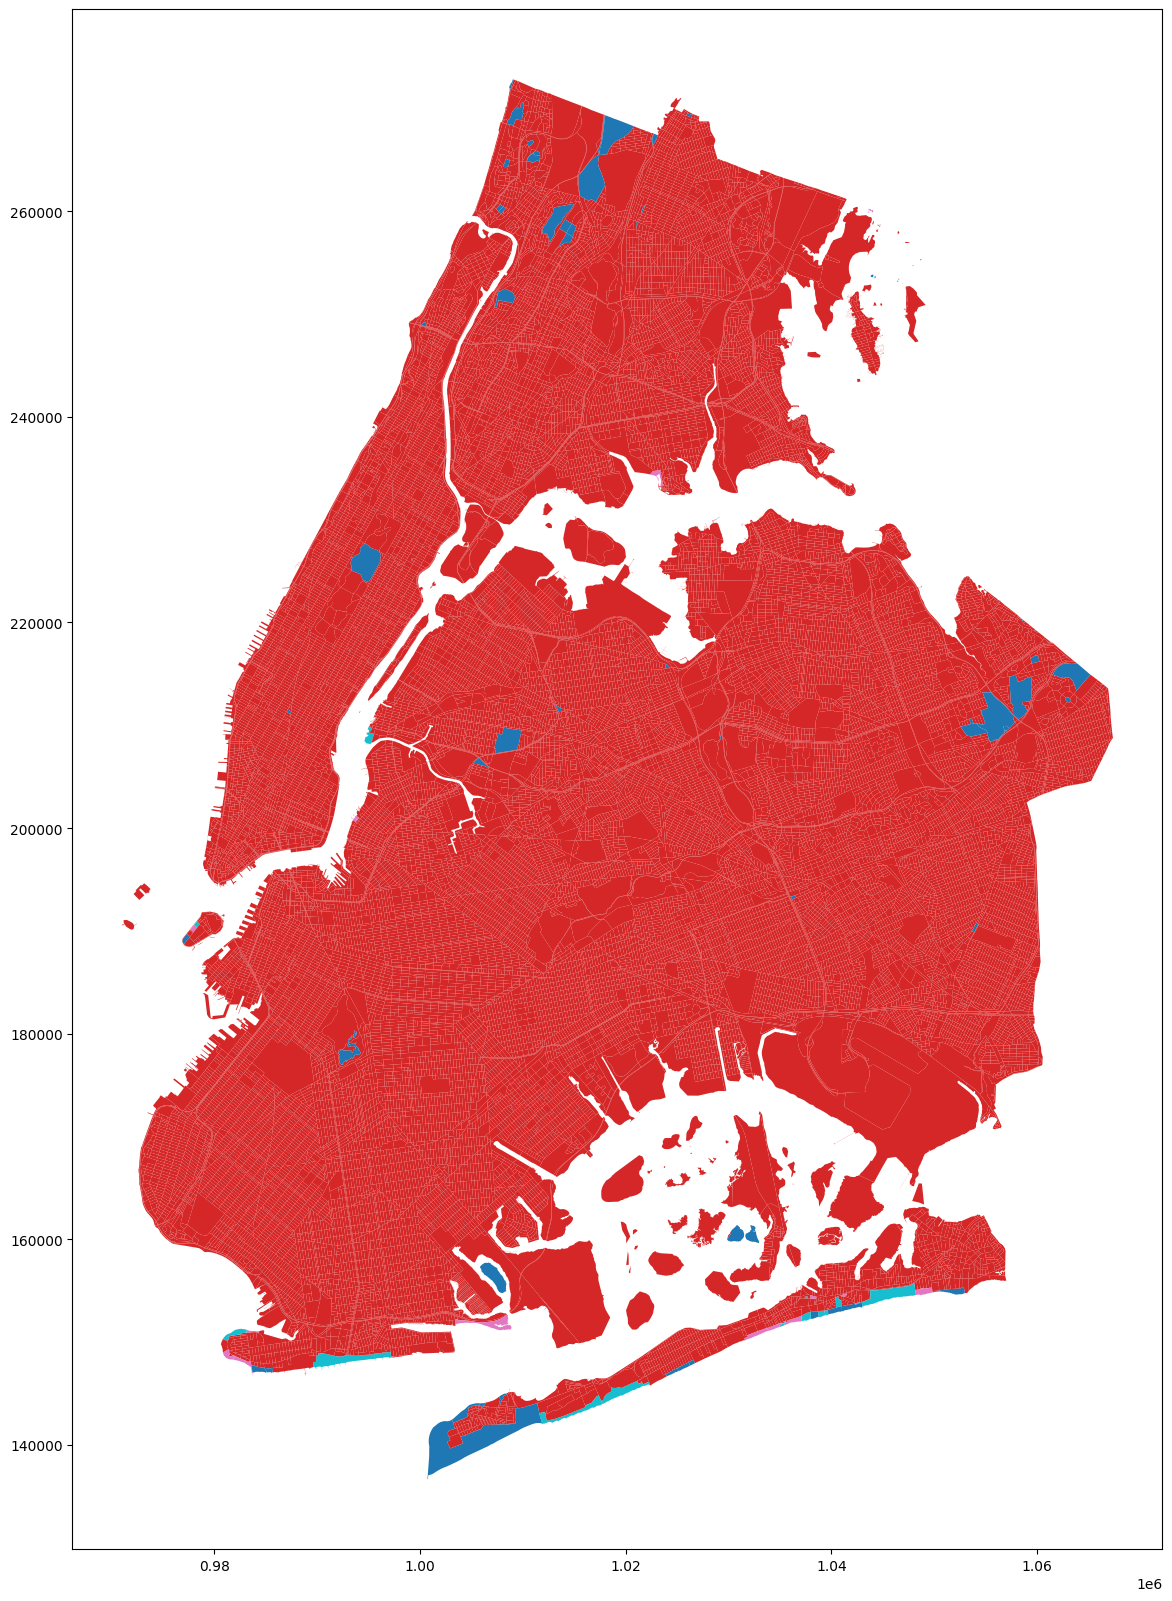

In [20]:
df.plot(column = 'cluster_db3',
        categorical=True,
        figsize = (25, 20))

<AxesSubplot: >

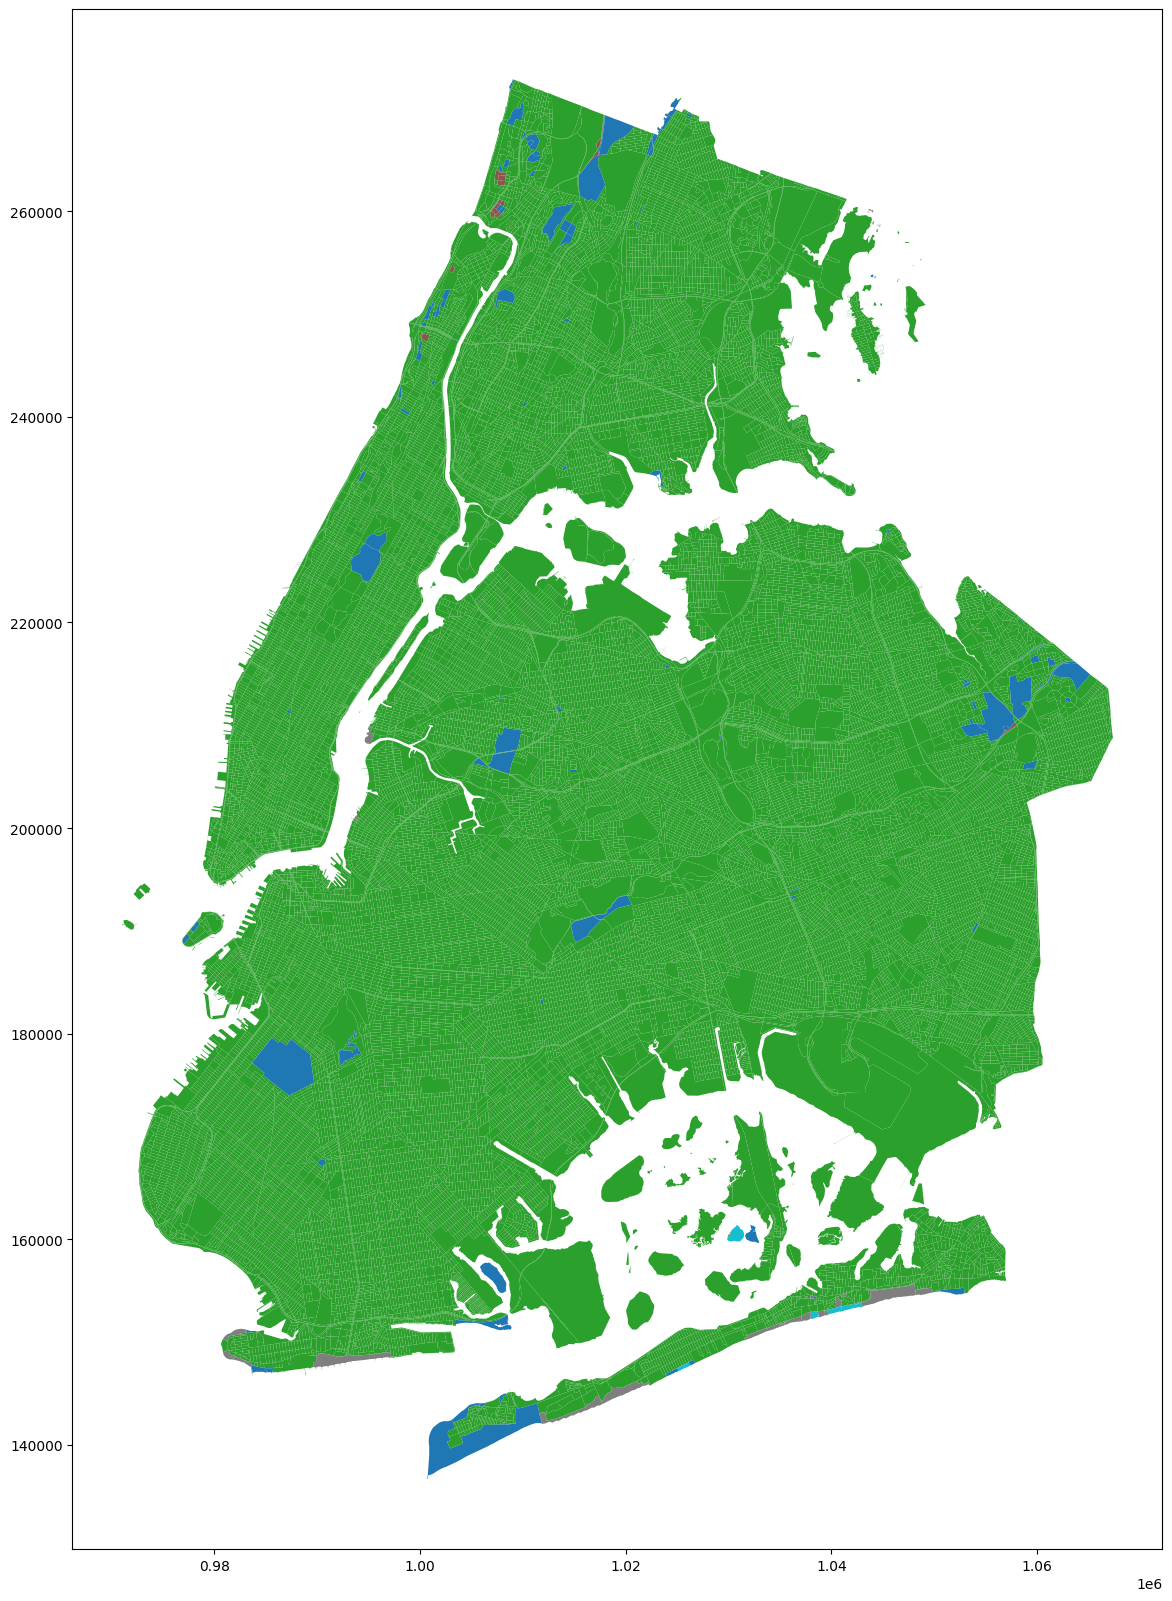

In [21]:
df.plot(column = 'cluster_db4',
        categorical=True,
        figsize = (25, 20))

### Visualizations

In [26]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [28]:
# plt.title('DBSCAN Clustering Dendrogram: 3 Clusters')
# plot_dendrogram(db, truncate_mode = 'level', p = 2, leaf_rotation = 30, leaf_font_size = 9)
# plt.xlabel('Number of Points in Node')
# plt.show()